# Evaluating Segment Anything Models for Microscopy

This notebook shows how to use Segment Anything (SAM) for automatic and interactive instance segmentation, using the corresponding functionality from `µsam` (Segment Anything for Microscopy) python library. We use DIC microscopy images from the Cell Tracking Challenge, DIC-C2DH-HeLa, HeLa cells on a flat glass (from [Maška et al.](https://doi.org/10.1038/s41592-023-01879-y)) in this notebook. The functionalities shown here should work for your (microscopy) images too.

We demonstrate using three different functionalities in the batched mode (for multiple images):
1. Automatic Mask Generation (AMG): The "Segment Anything" feature where positive point prompts are sampled in a grid over the entire image to perform instance segmentation.
2. Automatic Instance Segmentation (AIS): A new feature introduced in µsam where we train an additional decoder to perform automatic instance segmentation. This method is much faster in AMG and yields better results if it is applied to data that is similar to the finetuning dataset.
3. Interactive Segmentation (using Points and Box): The feature which reproduces the interactive segmentatione experience by deriving positive point prompts / box prompts to segment the objects, and iteratively improve the segmentations by placing a pair of positive (to improve the segmentation) and negative (to rectify the incorrect segmentation) point prompts.

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next collapsible section guides you through the installation for you if you are using it. You can skip them if you have `micro_sam` installed.

<details>

<summary><strong>Click here for more installation details.</strong></summary>

## Install `condacolab` for Package Management

**IMPORTANT**: This step is only necessary if you are running this notebook in Kaggle Notebooks (tested) / Google Colab. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer with `micro_sam` already installed.**

The first step for running the notebook on the above mentioned cloud platforms is to have a package manager to install `µsam` and other relevant packages.

**NOTE**: Please run the next two blocks of code in new cells one after the other.

# Step 1: Install `condacolab` on Kaggle Notebooks (tested) / Google Colab for installing conda and other related package managers.

```bash
!pip install -q condacolab
import condacolab
condacolab.install()
```

> **NOTE**: When you run the previous block of code, the kernel should restart automatically in Kaggle Notebooks (tested). Please proceed further without the need of any manual kernel restarts.

# Step 2: Validate if `condacolab` was installed correctly.

```bash
import condacolab
condacolab.check()
```

> If you see `✨🍰✨ Everything looks OK!` in the previous code block's output, you are good to proceed the next code block!

## Checking system information

```python
# Check if we are running this notebook on Kaggle, Google Colab or local compute resources.
import os
current_spot = os.getcwd()

if current_spot.startswith("/kaggle/working"):
    print("Kaggle says hi!")
    root_dir = "/kaggle/working"

elif current_spot.startswith("/content"):
    print("Google Colab says hi!")
    print(" NOTE: The scripts have not been tested on Google Colab, you might need to adapt the installations a bit.")
    root_dir = "/content"

else:
    msg = "You are using a behind-the-scenes resource. Follow our installation instructions here:"
    msg += " https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation"
    print(msg)
    root_dir = ""  # overwrite to set the root directory, where the data, checkpoints, and all relevant stuff will be stored
```

### Installation

The next code block will install the `micro_sam` library on Kaggle Notebooks. **Please skip these cells and go to `Importing the libraries` if you are running the notebook on your own computer.**

```bash
# Install `micro-sam` from `conda-forge`.
!mamba install -y -q -c conda-forge micro_sam > /dev/null 2>&1
!pip uninstall -y --quiet napari  # GUI backends are not supported in Kaggle / Google Colab, let's remove it to avoid errors.
```

> NOTE:
Known Issues on **Kaggle Notebooks** (for the `Importing the libraries` section below):

1. ```bash
    2024-05-08 14:56:42.941557: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
    2024-05-08 14:56:42.941680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
    2024-05-08 14:56:43.062385: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
    ```

    - We have received this warning while testing this notebook on Kaggle. We suspect that the complains originate from the tensorflow suite. It does not lead to any issues while making use of the installed packages. You can proceed and ignore the warnings.

## Importing the libraries

In [ ]:
import os
from glob import glob

import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

from torch_em.util.util import get_random_colors

from micro_sam.util import get_sam_model
from micro_sam.evaluation import inference
from micro_sam.evaluation.model_comparison import _enhance_image
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.evaluation.evaluation import run_evaluation, run_evaluation_for_iterative_prompting

# HACK: Explicitly setting the image decoder as Kaggle seems to not be able to see it.
import tifffile
import imagecodecs

# Explicitly set the decoder
tifffile.tifffile.imagecodecs = imagecodecs

2025-04-16 08:47:45.626664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744793265.821880     166 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744793265.878807     166 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Let's download the dataset

In [ ]:
# NOTE: Please set 'root_dir' to the desired path, either where your data exists, or where you would like to download the data.
root_dir = os.getcwd()  # Overwrite this to point to your desired path.

DATA_FOLDER = os.path.join(root_dir, "data")
os.makedirs(DATA_FOLDER, exist_ok=True)

# This will download the image and segmentation data for training.
image_dir = fetch_tracking_example_data(DATA_FOLDER)
segmentation_dir = fetch_tracking_segmentation_data(DATA_FOLDER)

100%|█████████████████████████████████████| 41.5M/41.5M [00:00<00:00, 43.4GB/s]
Extracting 'DIC-C2DH-HeLa/01/t000.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t001.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t002.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t003.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t004.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t005.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/DIC-C2DH-HeLa.zip.unzip'
Extracting 'DIC-C2DH-HeLa/01/t006.tif' from '/kaggle/working/data/DIC-C2DH-HeLa.zip' to '/kaggle/working/data/

Example data directory is: /kaggle/working/data


100%|███████████████████████████████████████| 725k/725k [00:00<00:00, 1.11GB/s]
Extracting 'masks/mask_0000.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0001.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0002.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0003.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0004.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0005.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Extracting 'masks/mask_0006.tif' from '/kaggle/working/data/hela-ctc-01-gt.zip' to '/kaggle/working/data/hela-ctc-01-gt.zip.unzip'
Ext

## Let's create our necessary functionality

With reference to our suggestion for batched evaluation of the Segment Anything models (see our [documentation](https://github.com/computational-cell-analytics/micro-sam/tree/master/finetuning/evaluation#how-to-run-the-evaluation-scripts-on-your-own-data) for details) on your own data, the first step is to create a convenience function to wrap the input images and respective instance labels around a function.

In [ ]:
def get_paths(n_val_images=2, split=None):
    """For this dataset, we have a total of 84 images.

    We choose:
        - The first 2 images as the validation images, for grid search (relevant for AMG ans AIS)
        - The next 82 images as the test images, for running the inference(s).
    """
    image_paths = sorted(glob(os.path.join(image_dir, "*")))
    gt_paths = sorted(glob(os.path.join(segmentation_dir, "*")))

    if split is None:
        return image_paths, gt_paths

    else:
        if split == "val":
            return image_paths[:n_val_images], gt_paths[:n_val_images]
        elif split == "test":
            return image_paths[n_val_images:], gt_paths[n_val_images:]
        else:
            raise ValueError(f"'{split}' is not a valid split name.")


def visualize_automatic_segmentations(mode, experiment_dir, show_all_images=False):
    """This functionality helps visualizing both the automatic segmentations
    from the Segment Anything models.
    """
    if mode == "amg":
        prediction_dir = os.path.join(experiment_dir, "amg", "inference")
    elif mode == "ais":
        prediction_dir = os.path.join(experiment_dir, "instance_segmentation_with_decoder", "inference")
    else:
        raise ValueError("Please choose the 'mode' from either 'amg' / 'ais'.")

    for gt_path in test_gt_paths:
        gt_id = os.path.split(gt_path)[-1]
        image_path = os.path.join(image_dir, f"t{gt_id[-7:]}")
        amg_path = os.path.join(prediction_dir, f"t{gt_id[-7:]}")

        image = imageio.imread(image_path)
        gt = imageio.imread(gt_path)
        amg = imageio.imread(amg_path)

        plot_samples(image, gt, amg)

        if not show_all_images:
            break


def visualize_interactive_segmentations(mode, prediction_dir, show_all_images=False):
    """This functionality helps visualizing the interactive segmentations and
    the consecutive iterations from the Segment Anything models.
    """
    mode = mode.lower()
    assert mode in ["point", "box"]

    for gt_path in test_gt_paths:
        gt_id = os.path.split(gt_path)[-1]
        image_path = os.path.join(image_dir, f"t{gt_id[-7:]}")

        image = imageio.imread(image_path)
        gt = imageio.imread(gt_path)
        iter0 = imageio.imread(os.path.join(prediction_dir, "iteration00", f"t{gt_id[-7:]}"))
        iter1 = imageio.imread(os.path.join(prediction_dir, "iteration01", f"t{gt_id[-7:]}"))
        iter2 = imageio.imread(os.path.join(prediction_dir, "iteration02", f"t{gt_id[-7:]}"))
        iter3 = imageio.imread(os.path.join(prediction_dir, "iteration03", f"t{gt_id[-7:]}"))
        iter4 = imageio.imread(os.path.join(prediction_dir, "iteration04", f"t{gt_id[-7:]}"))
        iter5 = imageio.imread(os.path.join(prediction_dir, "iteration05", f"t{gt_id[-7:]}"))
        iter6 = imageio.imread(os.path.join(prediction_dir, "iteration06", f"t{gt_id[-7:]}"))
        iter7 = imageio.imread(os.path.join(prediction_dir, "iteration07", f"t{gt_id[-7:]}"))

        fig, ax = plt.subplots(1, 10, figsize=(40, 40))

        ax[0].imshow(_enhance_image(image, do_norm=False), cmap="gray")
        ax[0].axis("off")
        ax[0].set_title("Image")

        gt = connected_components(gt)
        ax[1].imshow(gt, cmap=get_random_colors(gt), interpolation="nearest")
        ax[1].axis("off")
        ax[1].set_title("Ground Truth")

        ax[2].imshow(iter0, cmap=get_random_colors(iter0), interpolation="nearest")
        ax[2].axis("off")
        ax[2].set_title(f"Interactive ({mode.title()})")

        ax[3].imshow(iter1, cmap=get_random_colors(iter1), interpolation="nearest")
        ax[3].axis("off")
        ax[3].set_title("Iteration 1")

        ax[4].imshow(iter2, cmap=get_random_colors(iter2), interpolation="nearest")
        ax[4].axis("off")
        ax[4].set_title("Iteration 2")

        ax[5].imshow(iter3, cmap=get_random_colors(iter3), interpolation="nearest")
        ax[5].axis("off")
        ax[5].set_title("Iteration 3")

        ax[6].imshow(iter4, cmap=get_random_colors(iter4), interpolation="nearest")
        ax[6].axis("off")
        ax[6].set_title("Iteration 4")

        ax[7].imshow(iter5, cmap=get_random_colors(iter5), interpolation="nearest")
        ax[7].axis("off")
        ax[7].set_title("Iteration 5")

        ax[8].imshow(iter6, cmap=get_random_colors(iter6), interpolation="nearest")
        ax[8].axis("off")
        ax[8].set_title("Iteration 6")

        ax[9].imshow(iter7, cmap=get_random_colors(iter7), interpolation="nearest")
        ax[9].axis("off")
        ax[9].set_title("Iteration 7")

        plt.show()
        plt.close()

        if not show_all_images:
            break

## Let's visualize how our samples look

We check out the example data visually with matplotlib and visualize the images and the ground-truth segmentations.

In [8]:
# Convenience function to plot images side-by-side
def plot_samples(image, gt, segmentation=None):
    n_images = 2 if segmentation is None else 3
    fig, ax = plt.subplots(1, n_images, figsize=(10, 10))

    ax[0].imshow(_enhance_image(image, do_norm=False), cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Image")

    gt = connected_components(gt)
    ax[1].imshow(gt, cmap=get_random_colors(gt), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth")

    if n_images == 3:
        ax[2].imshow(segmentation, cmap=get_random_colors(segmentation), interpolation="nearest")
        ax[2].axis("off")
        ax[2].set_title("Prediction")

    plt.show()
    plt.close()

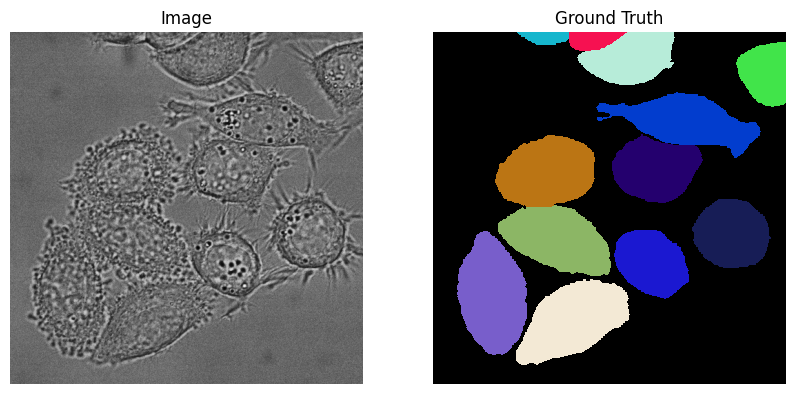

In [9]:
image_paths, segmentation_paths = get_paths(split="test")

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    segmentation = imageio.imread(segmentation_path)

    plot_samples(image=image, gt=segmentation)

    break  # comment this out in case you want to visualize all the images

### Let's start with Automatic Mask Generation (AMG) - the "Segment Anything" feature

In [10]:
# We define the paths to the validation inputs and the test inputs
# We will use these path variables throughout the scripts
val_image_paths, val_gt_paths = get_paths(split="val")
test_image_paths, test_gt_paths = get_paths(split="test")

The supported models are documented [here](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#choosing-a-model). The abbreviations can be used as it is to initialize `micro-sam` with the default SAM / LM generalist / EM generalist models.

In [11]:
checkpoint=None  # overwrite this to load your custom model checkpoints
model_type = "vit_b"  # overwrite with your desired choice of model (see the supported models in `micro-sam` for details.)
experiment_folder = os.path.join(root_dir, "experiment_dir", "DIC-C2DH-HeLa", model_type)

# let's run the automatic mask generation
prediction_folder = inference.run_amg(
    checkpoint=checkpoint,
    model_type=model_type,
    experiment_folder=experiment_folder,
    val_image_paths=val_image_paths,
    val_gt_paths=val_gt_paths,
    test_image_paths=test_image_paths,
)

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 466GB/s]
Run instance segmentation grid-search: 100%|██████████| 2/2 [12:32<00:00, 376.18s/it]


Best grid-search result: 0.12113059947299075 with parmeters:
 pred_iou_thresh = 0.9, stability_score_thresh = 0.925



Run inference for automatic mask generation: 100%|██████████| 82/82 [13:15<00:00,  9.70s/it]


#### Let's evaluate our AMG predictions from the default Segment Anything model.

The metric we use here is the segmentation accuracy. The abbreviations: `msa`, `sa50` and `sa75` are the mean segmentation accuracy, segmentation accuracy over intersection over union at 50% and segmentation accuracy over intersection over union at 75%.

In [12]:
print("Evaluating", prediction_folder)
prediction_paths = sorted(glob(os.path.join(prediction_folder, "*")))
save_path = os.path.join(experiment_folder, "results", "amg.csv")
results = run_evaluation(
    gt_paths=test_gt_paths,
    prediction_paths=prediction_paths,
    save_path=save_path,
)
print(results)

Evaluating /kaggle/working/experiment_dir/DIC-C2DH-HeLa/vit_b/amg/inference


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.90it/s]


        mSA      SA50      SA75
0  0.095561  0.122464  0.109681


#### Let's investigate this further and visualize the AMG results

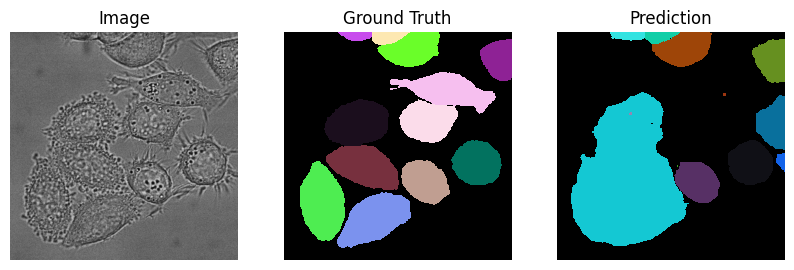

In [13]:
visualize_automatic_segmentations(
    mode="amg",  # choice of the automatic segmentation methods ['amg' / 'ais']
    experiment_dir=experiment_folder,  # path where all the outputs for the current experiments are stored, including the predictions
    show_all_images=False  # overwrite in case you want to visualize the predictions for all test images
)

#### Next, let's try AMG with the Light Microscopy (LM) Generalist Model

In [14]:
checkpoint=None  # overwrite in case you have custom checkpoints to load models from
model_type = "vit_b_lm"  # overwrite with your desired choice of model
experiment_folder = os.path.join(root_dir, "experiment_dir", "DIC-C2DH-HeLa", model_type)

prediction_folder = inference.run_amg(
    checkpoint=checkpoint,
    model_type=model_type,
    experiment_folder=experiment_folder,
    val_image_paths=val_image_paths,
    val_gt_paths=val_gt_paths,
    test_image_paths=test_image_paths,
)

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 503GB/s]
100%|█████████████████████████████████████| 44.1M/44.1M [00:00<00:00, 61.0GB/s]
Run instance segmentation grid-search: 100%|██████████| 2/2 [02:50<00:00, 85.29s/it]


Best grid-search result: 0.40127060439560436 with parmeters:
 pred_iou_thresh = 0.925, stability_score_thresh = 0.9



Run inference for automatic mask generation: 100%|██████████| 82/82 [09:38<00:00,  7.05s/it]


#### Let's evaluate the AMG predictions for the LM Generalist Model

In [15]:
print("Evaluating", prediction_folder)
prediction_paths = sorted(glob(os.path.join(prediction_folder, "*")))
save_path = os.path.join(experiment_folder, "results", "amg.csv")
results = run_evaluation(
    gt_paths=test_gt_paths,
    prediction_paths=prediction_paths,
    save_path=save_path,
    verbose=True,
)
print(results)

Evaluating /kaggle/working/experiment_dir/DIC-C2DH-HeLa/vit_b_lm/amg/inference


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.22it/s]

       mSA      SA50      SA75
0  0.27438  0.315138  0.314178


#### Let's investigate this further and visualize the AMG results

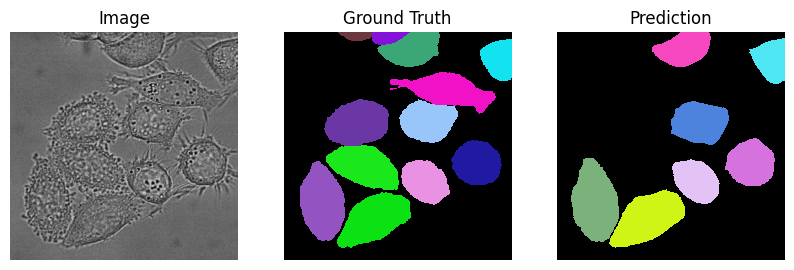

In [16]:
visualize_automatic_segmentations(
    mode="amg",  # choice of the automatic segmentation methods ['amg' / 'ais']
    experiment_dir=experiment_folder,  # path where all the outputs for the current experiments are stored, including the predictions
    show_all_images=False  # overwrite in case you want to visualize the predictions for all test images
)

#### Let's perform the automatic instance segmentation (AIS) with the LM Generalist Model

In [17]:
checkpoint=None  # overwrite in case you have custom checkpoints to load models from
model_type = "vit_b_lm"  # overwrite with your desired choice of model
experiment_folder = os.path.join(root_dir, "experiment_dir", "DIC-C2DH-HeLa", model_type)

prediction_folder = inference.run_instance_segmentation_with_decoder(
    checkpoint=checkpoint,
    model_type=model_type,
    experiment_folder=experiment_folder,
    val_image_paths=val_image_paths,
    val_gt_paths=val_gt_paths,
    test_image_paths=test_image_paths,
)

Run instance segmentation grid-search: 100%|██████████| 2/2 [01:42<00:00, 51.01s/it]


Best grid-search result: 0.6369250048197417 with parmeters:
 center_distance_threshold = 0.3, boundary_distance_threshold = 0.3, distance_smoothing = 1.2, min_size = 50.0



Run inference for automatic mask generation: 100%|██████████| 82/82 [00:36<00:00,  2.27it/s]


#### Let's evaluate AIS predictions for the LM Generalist Model

In [18]:
print("Evaluating", prediction_folder)
prediction_paths = sorted(glob(os.path.join(prediction_folder, "*")))
save_path = os.path.join(experiment_folder, "results", "instance_segmentation_with_decoder.csv")
results = run_evaluation(
    gt_paths=test_gt_paths,
    prediction_paths=prediction_paths,
    save_path=save_path
)
print(results)

Evaluating /kaggle/working/experiment_dir/DIC-C2DH-HeLa/vit_b_lm/instance_segmentation_with_decoder/inference


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.57it/s]

        mSA      SA50      SA75
0  0.621594  0.769922  0.729153


#### Let's investigate this further and visualize the AIS results

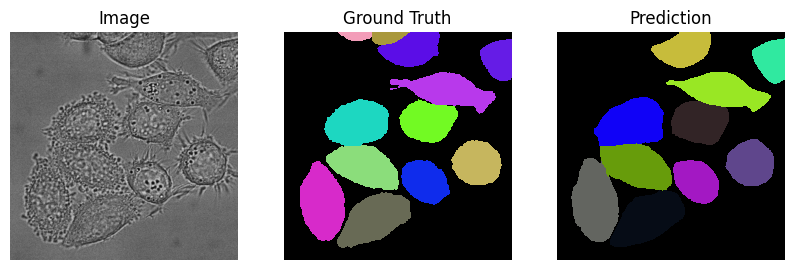

In [19]:
visualize_automatic_segmentations(
    mode="ais",  # choice of the automatic segmentation methods ['amg' / 'ais']
    experiment_dir=experiment_folder,  # path where all the outputs for the current experiments are stored, including the predictions
    show_all_images=False  # overwrite in case you want to visualize the predictions for all test images
)

### Next, let's try Interactive Segmentation

#### Let's start with the default Segment Anything model

In [20]:
checkpoint=None  # overwrite in case you have custom checkpoints to load models from
model_type = "vit_b"  # overwrite with your desired choice of model
experiment_folder = os.path.join(root_dir, "experiment_dir", "DIC-C2DH-HeLa", model_type)

predictor = get_sam_model(model_type=model_type, checkpoint_path=checkpoint)

prediction_dir = os.path.join(experiment_folder, "start_with_point_prompt")
embedding_folder = os.path.join(experiment_folder, "embeddings")

inference.run_inference_with_iterative_prompting(
    predictor=predictor,
    image_paths=test_image_paths,
    gt_paths=test_gt_paths,
    embedding_dir=embedding_folder,
    prediction_dir=prediction_dir,
    start_with_box_prompt=False,  # overwrite to start with the box prompt
    use_masks=False,  # overwrite to use logits masks for iterative prompting
)

Run inference with iterative prompting for all images: 100%|██████████| 82/82 [02:17<00:00,  1.68s/it]


#### Let's evaluate the interactive segmentation results for iterative prompting, starting with point prompts

In [21]:
run_evaluation_for_iterative_prompting(
    gt_paths=test_gt_paths,
    prediction_root=prediction_dir,
    experiment_folder=experiment_folder,
    start_with_box_prompt=False,
)

Evaluating iteration00


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 32.75it/s]


Evaluating iteration01


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 35.53it/s]


Evaluating iteration02


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 35.48it/s]


Evaluating iteration03


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 35.68it/s]


Evaluating iteration04


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 33.73it/s]


Evaluating iteration05


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 36.04it/s]


Evaluating iteration06


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 35.79it/s]


Evaluating iteration07


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 34.80it/s]


#### Let's investigate this further and visualize the iterative prompting results, starting with point prompts

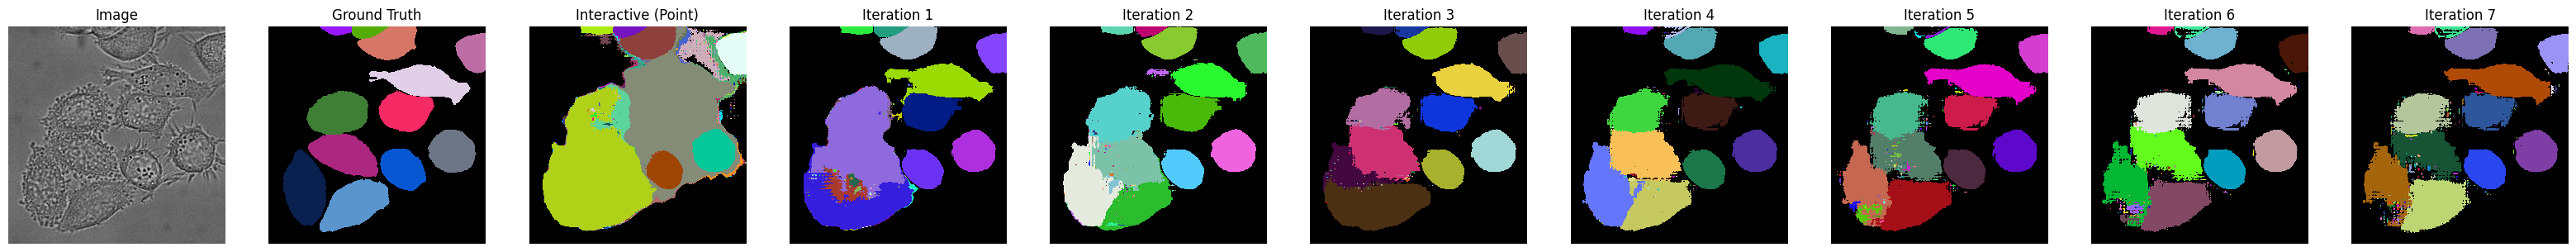

In [22]:
visualize_interactive_segmentations(
    mode="point",  # choice of the first prompt for the interactive segmentation
    prediction_dir=prediction_dir,  # path where the predictions for all iterations are stored
    show_all_images=False  # overwrite in case you want to vislualize the predictions for all test images
)

We observe that the default models are not as good for points

#### Let's try starting with box prompts instead

In [23]:
prediction_dir = os.path.join(experiment_folder, "start_with_box_prompt")
embedding_folder = os.path.join(experiment_folder, "embeddings")

inference.run_inference_with_iterative_prompting(
    predictor=predictor,
    image_paths=test_image_paths,
    gt_paths=test_gt_paths,
    embedding_dir=embedding_folder,
    prediction_dir=prediction_dir,
    start_with_box_prompt=True,  # overwrite to start with the box prompt
    use_masks=False,  # overwrite to use logits masks for iterative prompting
)

Run inference with iterative prompting for all images: 100%|██████████| 82/82 [01:43<00:00,  1.27s/it]


#### Let's evaluate the interactive segmentation results for iterative prompting, starting with box prompts

In [24]:
run_evaluation_for_iterative_prompting(
    gt_paths=test_gt_paths,
    prediction_root=prediction_dir,
    experiment_folder=experiment_folder,
    start_with_box_prompt=True,  # overwrite th evaluate the iterative prompting starting with box
)

Evaluating iteration00


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.88it/s]


Evaluating iteration01


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.95it/s]


Evaluating iteration02


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.14it/s]


Evaluating iteration03


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.50it/s]


Evaluating iteration04


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.02it/s]


Evaluating iteration05


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 36.79it/s]


Evaluating iteration06


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 36.71it/s]


Evaluating iteration07


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 36.98it/s]


#### Let's investigate this further and visualize the iterative prompting results, starting with box prompts

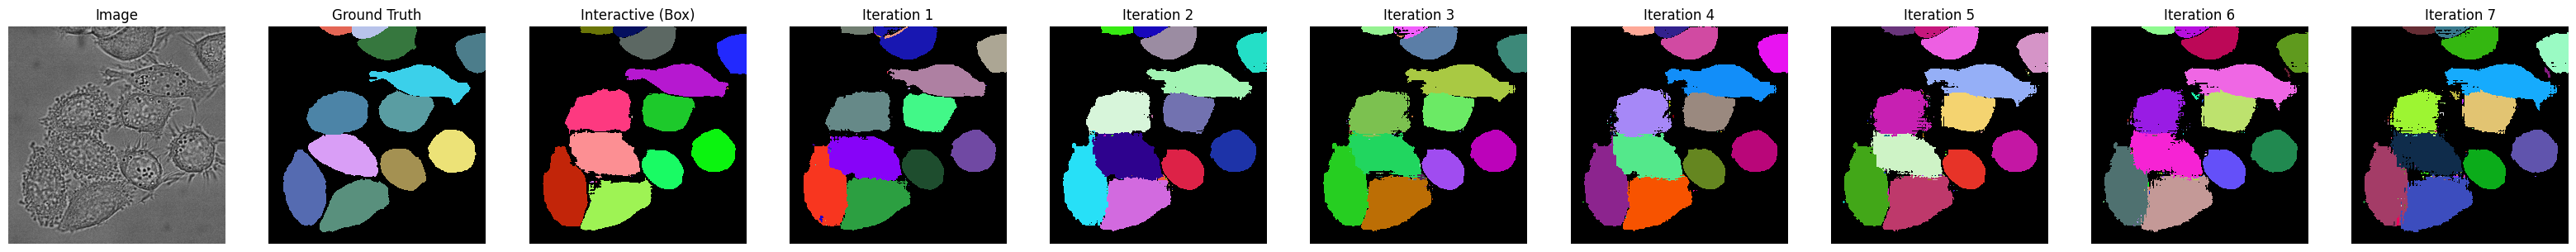

In [25]:
visualize_interactive_segmentations(
    mode="box",  # choice of the first prompt for the interactive segmentation
    prediction_dir=prediction_dir,  # path where the predictions for all iterations are stored
    show_all_images=False  # overwrite in case you want to vislualize the predictions for all test images
)

#### Let's try the LM Generalist Segment Anything models

In [26]:
checkpoint=None  # overwrite in case you have custom checkpoints to load models from
model_type = "vit_b_lm"  # overwrite with your desired choice of model
experiment_folder = os.path.join(root_dir, "experiment_dir", "DIC-C2DH-HeLa", model_type)

predictor = get_sam_model(model_type=model_type, checkpoint_path=checkpoint)

In [27]:
prediction_dir = os.path.join(experiment_folder, "start_with_point_prompt")
embedding_folder = os.path.join(experiment_folder, "embeddings")

inference.run_inference_with_iterative_prompting(
    predictor=predictor,
    image_paths=test_image_paths,
    gt_paths=test_gt_paths,
    embedding_dir=embedding_folder,
    prediction_dir=prediction_dir,
    start_with_box_prompt=False,  # overwrite to start with the box prompt
    use_masks=False,  # overwrite to use logits masks for iterative prompting
)

Run inference with iterative prompting for all images: 100%|██████████| 82/82 [02:16<00:00,  1.66s/it]


#### Let's evaluate the interactive segmentation results for iterative prompting, starting with point prompts

In [28]:
run_evaluation_for_iterative_prompting(
    gt_paths=test_gt_paths,
    prediction_root=prediction_dir,
    experiment_folder=experiment_folder,
    start_with_box_prompt=False,  # overwrite th evaluate the iterative prompting starting with box
)

Evaluating iteration00


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.95it/s]


Evaluating iteration01


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.77it/s]


Evaluating iteration02


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.99it/s]


Evaluating iteration03


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.42it/s]


Evaluating iteration04


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.62it/s]


Evaluating iteration05


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.88it/s]


Evaluating iteration06


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.94it/s]


Evaluating iteration07


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 38.20it/s]


#### Let's investigate this further and visualize the iterative prompting results, starting with point prompts

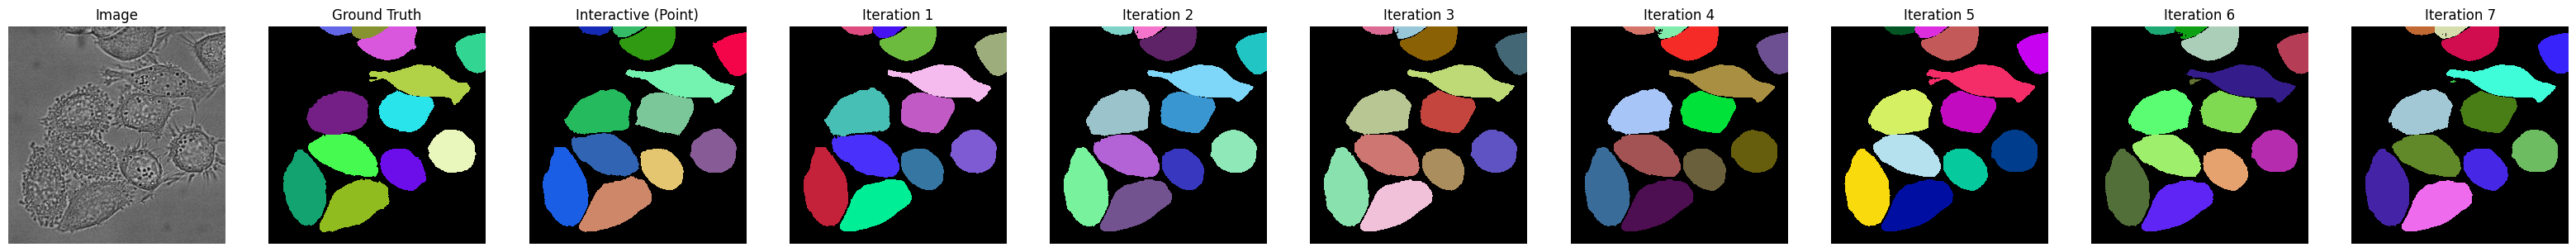

In [29]:
visualize_interactive_segmentations(
    mode="point",  # choice of the first prompt for the interactive segmentation
    prediction_dir=prediction_dir,  # path where the predictions for all iterations are stored
    show_all_images=False  # overwrite in case you want to vislualize the predictions for all test images
)

#### Let's try starting with box prompts instead

In [30]:
prediction_dir = os.path.join(experiment_folder, "start_with_box_prompt")
embedding_folder = os.path.join(experiment_folder, "embeddings")

inference.run_inference_with_iterative_prompting(
    predictor=predictor,
    image_paths=test_image_paths,
    gt_paths=test_gt_paths,
    embedding_dir=embedding_folder,
    prediction_dir=prediction_dir,
    start_with_box_prompt=True,  # overwrite to start with the box prompt
    use_masks=False,  # overwrite to use logits masks for iterative prompting
)

Run inference with iterative prompting for all images: 100%|██████████| 82/82 [01:43<00:00,  1.26s/it]


#### Let's evaluate the interactive segmentation results for iterative prompting, starting with box prompts

In [31]:
run_evaluation_for_iterative_prompting(
    gt_paths=test_gt_paths,
    prediction_root=prediction_dir,
    experiment_folder=experiment_folder,
    start_with_box_prompt=True,  # overwrite the evaluate the iterative prompting starting with box
)

Evaluating iteration00


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.81it/s]


Evaluating iteration01


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.65it/s]


Evaluating iteration02


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.88it/s]


Evaluating iteration03


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.12it/s]


Evaluating iteration04


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 39.81it/s]


Evaluating iteration05


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.07it/s]


Evaluating iteration06


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.45it/s]


Evaluating iteration07


Evaluate predictions: 100%|██████████| 82/82 [00:02<00:00, 40.52it/s]


#### Let's investigate this further and visualize the iterative prompting results, starting with box prompts

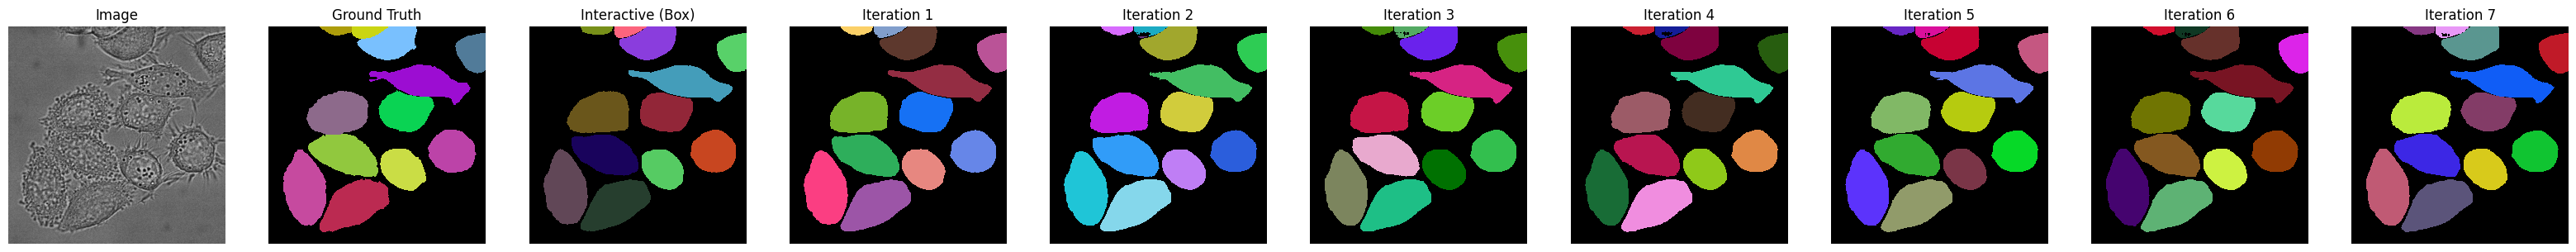

In [32]:
visualize_interactive_segmentations(
    mode="box",  # choice of the first prompt for the interactive segmentation
    prediction_dir=prediction_dir,  # path where the predictions for all iterations are stored
    show_all_images=False  # overwrite in case you want to vislualize the predictions for all test images
)

## What next?

Question: Are you happy with the default and / or LM Generalist Segment Anything Models for automatic and / or interactive segmentation?

1. If your answer is "YES", looks like you are good to go with getting started to annotate images looking similar to the (custom) data (you) used above. Feel free to test it on your custom data, and use the best method as a starting point to get started with annotating your data.
2. If you think the automatic and / or the interactive segmentations have missed out objects / produce undesired segmentations, and there's room for improvement:
    A. We recommend you to finetune the default SAM models OR the `µsam` model, based on your initial assessment of the segmentation quality of both models. This would potentially improve the automatic and / or interactive segmentation dataset for your desired segmentation task.

[Here](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb) is the link on how to get quickly started with finetuning on your custom dataset.

*This notebook was last an on May 5, 2025*